In [1]:
pip install tensorflow 

Note: you may need to restart the kernel to use updated packages.


In [2]:
from tqdm.auto import tqdm
import tensorflow as tf


In [3]:
!pip install transformers

In [4]:
from transformers import BertTokenizer

In [5]:
import pandas as pd
import numpy as np
import random
import os
import gc
from PIL import Image
from textwrap import wrap
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [6]:
num_words = 10000
max_review_len = 200

In [7]:
#assign column names manualy
dataset = pd.read_csv('train.csv',
                   header=None,
                   names=['Label', 'Review'])


In [8]:
dataset

,Label,Review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...
...,...,...
559995,2,Ryan was as good as everyone on yelp has claim...
559996,2,Professional \nFriendly\nOn time AND affordabl...
559997,1,Phone calls always go to voicemail and message...
559998,1,Looks like all of the good reviews have gone t...


In [24]:
dataset.head()

,Label,Review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560000 entries, 0 to 559999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Label   560000 non-null  int64 
 1   Review  560000 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.5+ MB


<AxesSubplot:xlabel='Label', ylabel='count'>

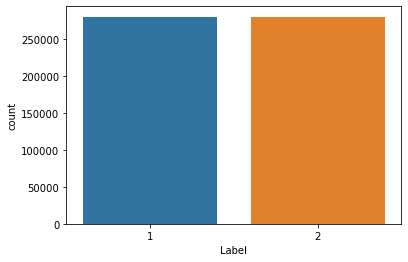

In [10]:
sns.countplot(x='Label', data=dataset)

<AxesSubplot:xlabel='Label', ylabel='count'>

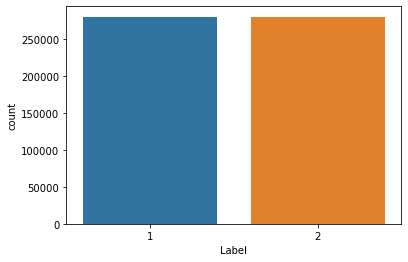

In [11]:
sns.countplot(x='Label', data=dataset)

## Calculate sentiment score using VADER

In [12]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [13]:
example = dataset['Review'][10]
print(example)

After waiting for almost 30 minutes to trade in an old phone part of the buy back program, our customer service rep incorrectly processed the transaction. This led to us waiting another 30 minutes for him to correct it. Don't visit this store if you want pleasant or good service.


In [14]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['After',
 'waiting',
 'for',
 'almost',
 '30',
 'minutes',
 'to',
 'trade',
 'in',
 'an']

In [15]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('After', 'IN'),
 ('waiting', 'VBG'),
 ('for', 'IN'),
 ('almost', 'RB'),
 ('30', 'CD'),
 ('minutes', 'NNS'),
 ('to', 'TO'),
 ('trade', 'VB'),
 ('in', 'IN'),
 ('an', 'DT')]

In [16]:
#using SentimentIntensityAnalyzer to get the neg/neu/pos/compound scores of the text.
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [17]:
import nltk

In [18]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [19]:
check = SentimentIntensityAnalyzer()

In [20]:
check.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [21]:
check.polarity_scores('I am not so happy!')

{'neg': 0.575, 'neu': 0.425, 'pos': 0.0, 'compound': -0.62}

In [22]:
check.polarity_scores('I dislike cricket!')

{'neg': 0.743, 'neu': 0.257, 'pos': 0.0, 'compound': -0.4389}

In [23]:
#polarity score for dataset
res = {}
for i, row in tqdm(dataset.iterrows(), total=len(dataset)):
    text = row['Review']
    res[text] = check.polarity_scores(text)

  0%|          | 0/560000 [00:00<?, ?it/s]

In [24]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Review'})
vaders = vaders.merge(dataset, how='left')

In [25]:
vaders.head()

,Review,neg,neu,pos,compound,Label
0,"Unfortunately, the frustration of being Dr. Go...",0.124,0.852,0.024,-0.8997,1
1,Been going to Dr. Goldberg for over 10 years. ...,0.000,0.957,0.043,0.6249,2
2,I don't know what Dr. Goldberg was like before...,0.141,0.770,0.090,-0.9439,1
3,I'm writing this review to give you a heads up...,0.045,0.865,0.089,0.6678,1
4,All the food is great here. But the best thing...,0.000,0.512,0.488,0.9958,2


In [26]:
vaders.head(15)

,Review,neg,neu,pos,compound,Label
0,"Unfortunately, the frustration of being Dr. Go...",0.124,0.852,0.024,-0.8997,1
1,Been going to Dr. Goldberg for over 10 years. ...,0.000,0.957,0.043,0.6249,2
2,I don't know what Dr. Goldberg was like before...,0.141,0.770,0.090,-0.9439,1
3,I'm writing this review to give you a heads up...,0.045,0.865,0.089,0.6678,1
4,All the food is great here. But the best thing...,0.000,0.512,0.488,0.9958,2
5,Wing sauce is like water. Pretty much a lot of...,0.000,0.794,0.206,0.9100,1
6,Owning a driving range inside the city limits ...,0.069,0.853,0.078,0.4657,1
7,This place is absolute garbage... Half of the...,0.000,0.945,0.055,0.7096,1
8,Before I finally made it over to this range I ...,0.026,0.907,0.067,0.7494,2
9,I drove by yesterday to get a sneak peak. It ...,0.021,0.847,0.131,0.8574,2


In [27]:
vaders.drop(['Label'],axis=1,inplace=True)  #drop the label 
vaders.head()

,Review,neg,neu,pos,compound
0,"Unfortunately, the frustration of being Dr. Go...",0.124,0.852,0.024,-0.8997
1,Been going to Dr. Goldberg for over 10 years. ...,0.000,0.957,0.043,0.6249
2,I don't know what Dr. Goldberg was like before...,0.141,0.770,0.090,-0.9439
3,I'm writing this review to give you a heads up...,0.045,0.865,0.089,0.6678
4,All the food is great here. But the best thing...,0.000,0.512,0.488,0.9958


In [28]:
#add different labels beforehand
vaders['Labels'] = pd.cut(vaders['compound'], 
                     bins=[0, 0.2, 0.4, 0.6, 0.8,1], 
                     labels=[1, 2, 3, 4, 5])

In [29]:
vaders['Labels'].fillna(value=1,inplace=True)  #to get the label of negative scores replace Nan with 1

In [30]:
vaders.head()

,Review,neg,neu,pos,compound,Labels
0,"Unfortunately, the frustration of being Dr. Go...",0.124,0.852,0.024,-0.8997,1
1,Been going to Dr. Goldberg for over 10 years. ...,0.000,0.957,0.043,0.6249,4
2,I don't know what Dr. Goldberg was like before...,0.141,0.770,0.090,-0.9439,1
3,I'm writing this review to give you a heads up...,0.045,0.865,0.089,0.6678,4
4,All the food is great here. But the best thing...,0.000,0.512,0.488,0.9958,5


In [32]:
vaders.to_csv('updated_dataset.csv')

In [34]:
df = pd.read_csv('updated_dataset.csv')
df.head()

,Review,neg,neu,pos,compound,Labels
0,"Unfortunately, the frustration of being Dr. Go...",0.124,0.852,0.024,-0.8997,1
1,Been going to Dr. Goldberg for over 10 years. ...,0.000,0.957,0.043,0.6249,4
2,I don't know what Dr. Goldberg was like before...,0.141,0.770,0.090,-0.9439,1
3,I'm writing this review to give you a heads up...,0.045,0.865,0.089,0.6678,4
4,All the food is great here. But the best thing...,0.000,0.512,0.488,0.9958,5


In [37]:
#plotting polarity analysis results

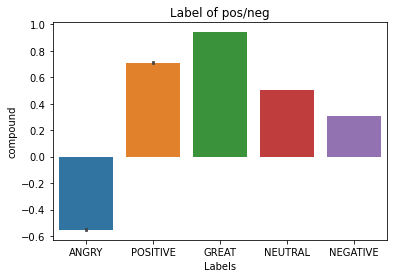

In [38]:
#plotting polarity analysis results
ax = sns.barplot(data=df, x='Labels', y='compound')
ax.set_title('Label of pos/neg')
plt.show()


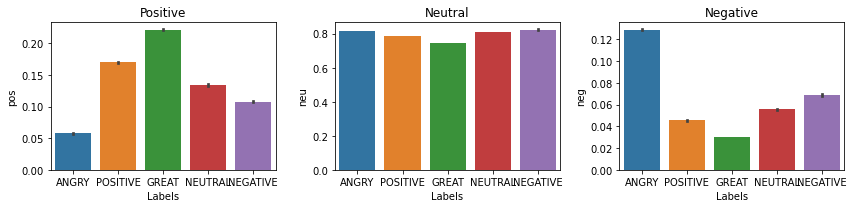

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=df, x='Labels', y='pos', ax=axs[0])
sns.barplot(data=df, x='Labels', y='neu', ax=axs[1])
sns.barplot(data=df, x='Labels', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Data cleaning

In [1]:
# Most basic stuff for EDA.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.
import string
import re

# Libraries for text preprocessing.
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import random

import os
import gc
from PIL import Image
from textwrap import wrap
import matplotlib.pyplot as plt
import matplotlib as mpl

# For customizing our plots.
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
# Setting some options for general use.
import os
stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250


In [2]:
#load the polarity scored dataset
df = pd.read_csv('updated_dataset.csv')
df.head()

,Review,neg,neu,pos,compound,Labels
0,"Unfortunately, the frustration of being Dr. Go...",0.124,0.852,0.024,-0.8997,1
1,Been going to Dr. Goldberg for over 10 years. ...,0.000,0.957,0.043,0.6249,4
2,I don't know what Dr. Goldberg was like before...,0.141,0.770,0.090,-0.9439,1
3,I'm writing this review to give you a heads up...,0.045,0.865,0.089,0.6678,4
4,All the food is great here. But the best thing...,0.000,0.512,0.488,0.9958,5


In [5]:
def remove_stopwords(text):
    tokens = []
    for token in text.split():
        if token not in stop:
            tokens.append(token)
    return " ".join(tokens)


def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions
df['text_clean'] = df['Review'].apply(lambda x: remove_stopwords(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_URL(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_html(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_punct(x))

In [6]:
df.head()

,Review,neg,neu,pos,compound,Labels,text_clean
0,"Unfortunately, the frustration of being Dr. Go...",0.124,0.852,0.024,-0.8997,1,Unfortunately frustration Dr Goldbergs patient...
1,Been going to Dr. Goldberg for over 10 years. ...,0.000,0.957,0.043,0.6249,4,Been going Dr Goldberg 10 years I think I one ...
2,I don't know what Dr. Goldberg was like before...,0.141,0.770,0.090,-0.9439,1,I know Dr Goldberg like moving Arizona let tel...
3,I'm writing this review to give you a heads up...,0.045,0.865,0.089,0.6678,4,Im writing review give heads see Doctor The of...
4,All the food is great here. But the best thing...,0.000,0.512,0.488,0.9958,5,All food great here But best thing wings Their...


In [7]:
updated = df[:5000]

In [8]:
updated.shape

(5000, 7)

In [9]:
updated.to_csv('training_data', index = False)

In [11]:
df = pd.read_csv('training_data')
df.head()
df.shape

(5000, 7)

In [12]:
df['Character Count'] = df['text_clean'].apply(lambda x: len(str(x)))

def plot_dist3(df_x, feature, title):
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax1.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax1, color='#e74c3c')
    ax1.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

C:\Users\KIIT\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


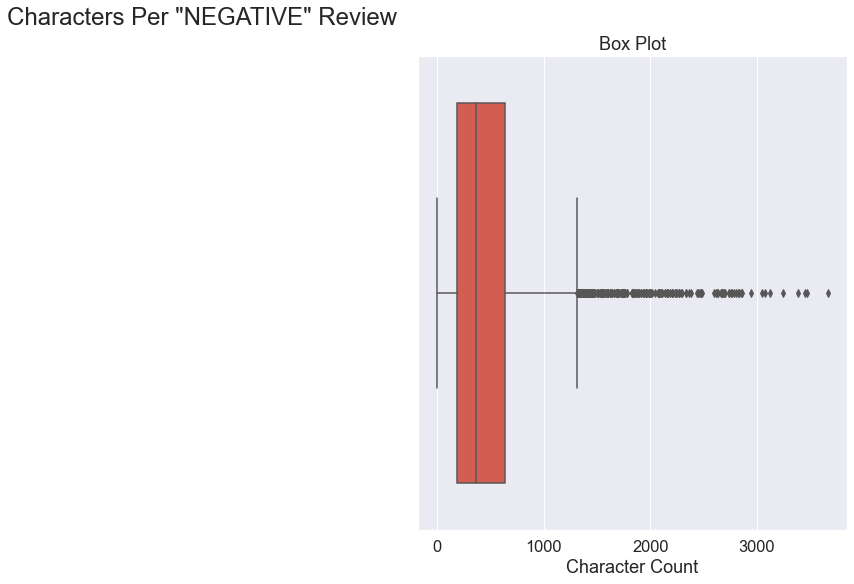

In [15]:
plot_dist3(df[df['Labels'] == 1], 'Character Count',
           'Characters Per "NEGATIVE" Review')

C:\Users\KIIT\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


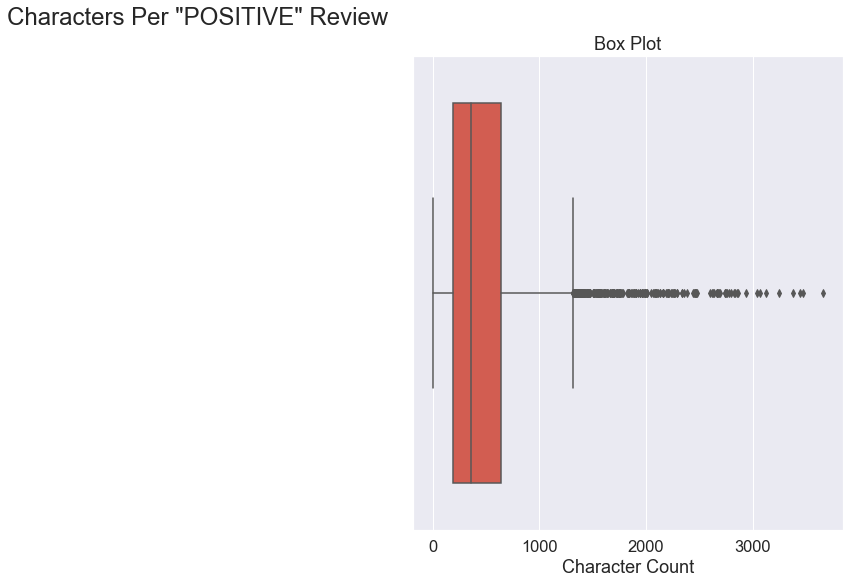

In [17]:
plot_dist3(df[df['Labels'] == 4], 'Character Count',
           'Characters Per "POSITIVE" Review')

In [ ]:
#decode_map = {1: "ANGRY", 2: "NEGATIVE", 3: "NEUTRAL", 4: "POSITIVE", 5: "GREAT"}
#def decode_sentiment(Labels):
#   return decode_map[int(Labels)]

In [ ]:
#%%time
#df.Labels = df.Labels.apply(lambda x: decode_sentiment(x))